File exists
Adj Close exists


,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,1003200,44.250000,1
1993-02-01,43.968750,44.250000,43.968750,44.250000,480500,44.343750,1
1993-02-02,44.218750,44.375000,44.125000,44.343750,201300,44.812500,1
1993-02-03,44.406250,44.843750,44.375000,44.812500,529400,45.000000,1
1993-02-04,44.968750,45.093750,44.468750,45.000000,531500,44.968750,0
...,...,...,...,...,...,...,...
2019-12-24,321.470001,321.519989,320.899994,321.230011,20270000,322.940002,1
2019-12-26,321.649994,322.950012,321.640015,322.940002,30911200,322.859985,0
2019-12-27,323.739990,323.799988,322.279999,322.859985,42528800,321.079987,0


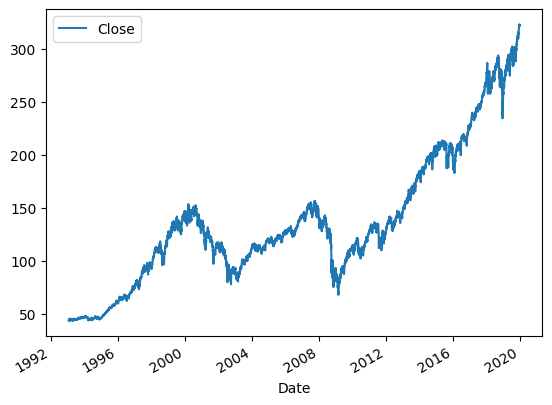

In [198]:
import yfinance as yf
import pandas as pd
import os


# get historical data for and index or stock for example using yfinance
def get_historical_data(ticker, start_date, end_date):
    # get data from yfinance
    data = yf.download(ticker, start=start_date, end=end_date)
    # save data to csv
    data.to_csv("sp500.csv")
    # return data
    return data


if os.path.exists("sp500.csv"):
    print("File exists")
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    print("File does not exist")
    sp500 = get_historical_data("SPY", "1990-01-01", "2020-01-01")
    sp500 = pd.read_csv("sp500.csv", index_col=0)

sp500.index = pd.to_datetime(sp500.index)
sp500.plot.line(y="Close", use_index=True)
# remove unnecessary columns
if "Dividends" in sp500.columns:
    print("Dividends exists")
    del sp500["Dividends"]
if "Stock Splits" in sp500.columns:
    print("Stock Splits exists")
    del sp500["Stock Splits"]

if "Adj Close" in sp500.columns:
    print("Adj Close exists")
    del sp500["Adj Close"]

sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()
sp500

In [199]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
# n_estimators: number of trees the more the better but more time consuming
# min_samples_split: number of samples required to split an internal node the more the less overfitting but more time consuming and less accurate

# its important to split it into train and test data in historical order
# we can't have future data in the training data only in the test data
train = sp500.iloc[:-100]
test = sp500.iloc[-100:-1]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

<Axes: xlabel='Date'>

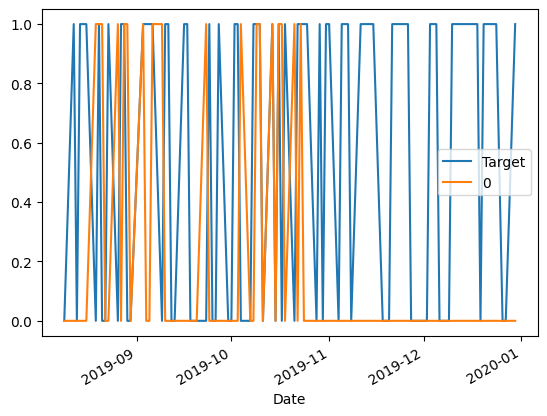

In [200]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [201]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [202]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i : (i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [203]:
predictions = backtest(sp500, model, predictors)
print(predictions["Predictions"].value_counts())
predictions

Predictions
1    2620
0    1660
Name: count, dtype: int64


,Target,Predictions
Date,,
2002-12-31,1,1
2003-01-02,1,1
2003-01-03,1,0
2003-01-06,0,0
2003-01-07,0,0
...,...,...
2019-12-24,1,1
2019-12-26,0,1
2019-12-27,0,1


In [204]:
precision_score(predictions["Target"], predictions["Predictions"], zero_division=1)

0.5450381679389313

In [205]:
predictions["Target"].value_counts() / predictions.shape[
    0
]  # how many times the market goes up or down

Target
1    0.546963
0    0.453037
Name: count, dtype: float64

In [206]:
# lets add some more predictors

horizons = [2, 5, 60, 250, 1000]
new_predictors = []


def add_horizon_predictors(data, horizon, new_predictors=new_predictors):
    data = data.copy()
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]
    return data


for horizon in horizons:
    sp500 = add_horizon_predictors(sp500, horizon)


# lets introduce on top of it some technical indicators
import ta


def add_technical_indicators(data, new_predictors=new_predictors):
    data = data.copy()
    data["RSI"] = ta.momentum.rsi(data["Close"])
    data["MACD"] = ta.trend.macd_diff(data["Close"])
    data["ATR"] = ta.volatility.average_true_range(
        data["High"], data["Low"], data["Close"]
    )
    data["ADX"] = ta.trend.adx(data["High"], data["Low"], data["Close"])
    data["OBV"] = ta.volume.on_balance_volume(data["Close"], data["Volume"])
    data["EMA"] = ta.trend.ema_indicator(data["Close"])
    data["SMA"] = ta.trend.sma_indicator(data["Close"])

    new_predictors += ["RSI", "MACD", "ATR", "ADX", "OBV", "EMA", "SMA"]

    return data


sp500 = add_technical_indicators(sp500)

In [207]:
# remove rows with missing values
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
print(new_predictors)
sp500

['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000', 'RSI', 'MACD', 'ATR', 'ADX', 'OBV', 'EMA', 'SMA']


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Trend_250,Close_Ratio_1000,Trend_1000,RSI,MACD,ATR,ADX,OBV,EMA,SMA
Date,,,,,,,,,,,,,,,,,,,,,
1997-01-14,76.687500,77.390625,76.500000,76.968750,2111200,76.781250,0,1.006230,1.0,1.015126,...,133.0,1.434841,520.0,62.848537,0.159540,1.155362,17.382053,44663900,75.454522,75.246094
1997-01-15,76.718750,77.203125,76.375000,76.781250,1583900,77.093750,1,0.998780,1.0,1.007091,...,132.0,1.430478,519.0,61.420211,0.181290,1.131988,16.222849,43080000,75.658634,75.321615
1997-01-16,77.031250,77.296875,76.500000,77.093750,1308400,77.562500,1,1.002031,1.0,1.006487,...,132.0,1.435424,519.0,62.932246,0.201633,1.108051,15.248396,44388400,75.879421,75.477865
1997-01-17,77.203125,77.750000,77.109375,77.562500,1604000,77.656250,1,1.003031,2.0,1.008820,...,132.0,1.443272,519.0,65.139306,0.229538,1.075780,14.829995,45992400,76.138356,75.787760
1997-01-20,77.750000,78.093750,77.468750,77.656250,1889900,78.281250,1,1.000604,2.0,1.005747,...,132.0,1.444139,519.0,65.580709,0.236267,1.043581,14.791142,47882300,76.371878,76.089844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,321.470001,321.519989,320.899994,321.230011,20270000,322.940002,1,1.000016,2.0,1.001546,...,148.0,1.261224,555.0,74.315350,0.264189,1.913723,29.333175,11247018900,318.588601,318.251671
2019-12-26,321.649994,322.950012,321.640015,322.940002,30911200,322.859985,0,1.002655,2.0,1.004779,...,149.0,1.267320,556.0,77.367438,0.292887,1.899885,30.543385,11277930100,319.258047,319.006671
2019-12-27,323.739990,323.799988,322.279999,322.859985,42528800,321.079987,0,0.999876,1.0,1.003306,...,148.0,1.266366,556.0,76.906903,0.261976,1.872750,31.895694,11235401300,319.812192,319.784170


In [208]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

In [209]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [210]:
predictions = backtest(sp500, model, new_predictors)
print(new_predictors)
print(predictions["Predictions"].value_counts())

print(predictions["Target"].value_counts() / predictions.shape[0])
precision = precision_score(
    predictions["Target"], predictions["Predictions"], zero_division=1
)
print(precision)

['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000', 'RSI', 'MACD', 'ATR', 'ADX', 'OBV', 'EMA', 'SMA']
Predictions
0.0    3007
1.0     273
Name: count, dtype: int64
Target
1    0.544817
0    0.455183
Name: count, dtype: float64
0.5860805860805861


In [211]:
# how much better is the model than the market
market = predictions["Target"].value_counts() / predictions.shape[0]

print("Precision: ", precision)
print("Market all long: ", market[1])

Precision:  0.5860805860805861
Market all long:  0.5448170731707317


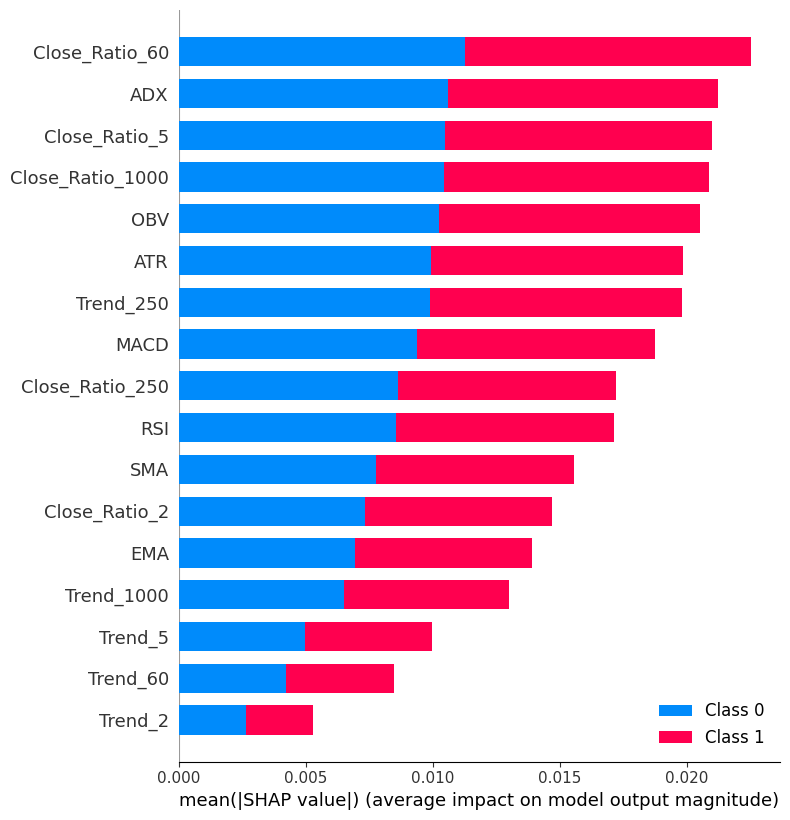

In [212]:
# shap plot to see which features are important
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sp500[new_predictors])
shap.summary_plot(shap_values, sp500[new_predictors], plot_type="bar")